In [1]:
import os
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from skimage import io, transform
from torchvision import transforms, utils
import torch
import numpy as np
import nibabel as nib
from random import randint
from PIL import Image
import torch.optim as optim
import time
import QuickNAT as QN
import torch.nn as nn
from livelossplot import PlotLosses

In [2]:
gpu_id = 1
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = str(gpu_id)

device = torch.device('cuda')

In [3]:
model = QN.QuickNAT(1,64,256)
model_params = list(model.parameters())
nb_param=0
for param in model.parameters():
    nb_param+=np.prod(list(param.data.size()))
print(nb_param)
model = model.to(device)

3308688


In [4]:
class TrainDataset(Dataset):
    """Training dataset with mask image mapping to classes"""
    def __init__(self, T1a_dir, parc5a_dir, transform=None):
        """
        Args:
            T1a_dir (string): Directory with T1w image in axial plane
            transform (callable): Optional transform to be applied on a sample
            parc5a_dir (string): Directory with parcellation scale 5 in axial plane
        """
        self.T1a_dir = T1a_dir
        self.transform = transform
        self.parc5a_dir = parc5a_dir
        
    def __len__(self):
        T1a_list = os.listdir(self.T1a_dir)
        return len(T1a_list)
    
    
    def __getitem__(self, idx):
        T1a_list = os.listdir(T1a_dir)
        parc5a_list = os.listdir(parc5a_dir)
        
        T1a_str = T1a_list[idx]
        
        T1a_arr = io.imread(os.path.join(T1a_dir, T1a_str))
        T1a_tensor = torch.from_numpy(T1a_arr)
        
        compose_T1 = transforms.Compose([transforms.ToPILImage(), 
                                         transforms.Resize((128,128),interpolation=Image.NEAREST),
                                         transforms.ToTensor(),
                                         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
        T1a_tensor = torch.unsqueeze(T1a_tensor, dim = 0)
        T1a_tensor = compose_T1(T1a_tensor)
              
        parc5a_str = parc5a_list[idx]
    
        parc5a_arr = io.imread(os.path.join(parc5a_dir, parc5a_str))
        parc5a_tensor = torch.from_numpy(parc5a_arr)
        
        compose = transforms.Compose([transforms.ToPILImage(),
                                      transforms.Resize((128,128),interpolation=Image.NEAREST), 
                                      transforms.ToTensor()])
        
        parc5a_tensor = torch.unsqueeze(parc5a_tensor, dim = 0)
        parc5a_tensor = compose(parc5a_tensor)
        parc5a_tensor = parc5a_tensor.squeeze()
        
        parc5a_tensor = torch.round(parc5a_tensor / 0.0039).byte()
      
        sample = {'T1a':T1a_tensor, 'parc5a':parc5a_tensor}
        
        if self.transform:
            T1a = self.transform(T1a_tensor)
            sample = {'T1a':T1a, 'parc5a':parc5a}
            
        return sample

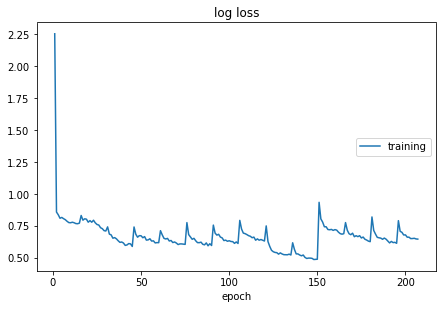

log loss:
training   (min:    0.485, max:    2.254, cur:    0.645)


In [ ]:
liveloss = PlotLosses()
for iteration in range(50):
    start=time.time()
    
    for sub_idx in range(330):

        T1a_dir = '/home/xiaoyu/MRIdata/T1w/axial/sub{}'.format(sub_idx)
   
        parc5a_dir = '/home/xiaoyu/MRIdata/parc_5/axial/sub{}'.format(sub_idx)
   
        T1a_list = os.listdir(T1a_dir)
  
        parc5a_list = os.listdir(parc5a_dir)

    
        if sub_idx == 0: # set sub0 as test set.
            print('\nT1w Axial slices num:',len(T1a_list))
            print('\nParc5 Axial slices num:',len(parc5a_list))

            continue
        
        print('\nSubject num:',sub_idx)   
        train_data = TrainDataset(T1a_dir=T1a_dir, parc5a_dir = parc5a_dir)
        dataloader = DataLoader(train_data, batch_size = 5, shuffle = True, num_workers = 4)
    
        criterion = nn.NLLLoss()
        optimizer = optim.Adam(model.parameters() ,lr=0.001)
    
        for epoch in range(15):
            logs = {}
   
    
            # define the running loss
            running_loss = 0
            running_error = 0
            num_batches=0
      
            for i_batch, sample_batched in enumerate(dataloader):
        
                optimizer.zero_grad()
        
                #get the inputs
                inputs, labels = sample_batched['T1a'], sample_batched['parc5a']
        
                inputs = inputs.to(device)
                labels = labels.to(device)

                inputs.requires_grad_()
        
                #forward + backward +optimize
                scores = model(inputs)
          
                # Define the loss
                loss = criterion(scores, labels.long()) 
                loss.backward()
                optimizer.step()
        
                # compute and accumulate stats
                running_loss += loss.detach().item()
       
                num_batches+=1 
    
            # AVERAGE STATS THEN DISPLAY    
            total_loss = running_loss/num_batches
   
            elapsed = (time.time()-start)/60
        
            print('epoch=',epoch, '\t time=', elapsed,'min', '\t loss=', total_loss )
            logs['log loss'] = total_loss
            
            liveloss.update(logs)
            liveloss.draw()
       
        print('Finish Training')
        
    print(iteration,'Iteration')
    